# Table of contents

Import libraries

Import data
1. Data observing
2. Data cleaning
3. EDA
4. Feature engineering
5. Data preprocessing
6. RFM Analysis
7. Model selection
8. Final conclusion

Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
import random
import matplotlib.ticker as tick


%matplotlib inline

## Import data

In [2]:
data = pd.read_csv('transactions.csv', sep=';')
codes = pd.read_csv('codes.csv', sep=';')
types = pd.read_csv('types.csv',sep=';')
train = pd.read_csv('train_set.csv', sep=';')
test = pd.read_csv('test_set.csv', sep=';')

In [3]:
# only clients from train
data = data.merge(train)

In [4]:
data.head()

,client_id,datetime,code,type,sum,target
0,96372458,421 06:33:15,6011,2010,-561478.94,0
1,96372458,270 06:16:18,6011,7010,224591.58,0
2,96372458,97 10:48:35,4829,2370,-11229.58,0
3,96372458,445 07:33:38,4829,2330,-417695.42,0
4,96372458,4 09:33:46,4814,1030,-2245.92,0


# 1. Data observe

## 1.1 Data description

In [5]:
# representing description of sum column(quartiles, median, mean, std, max, min)
data['sum'].describe()

count    9.182600e+04
mean    -1.666997e+04
std      6.232297e+05
min     -4.150030e+07
25%     -2.156079e+04
50%     -5.239160e+03
75%     -1.122960e+03
max      6.737747e+07
Name: sum, dtype: float64

In [6]:
# get rid of '-' sign
data_abs = data.copy()
data_abs['abs_sum'] = data['sum'].apply(lambda x: abs(x))

In [7]:
# describe absolute values for sum
data_abs['abs_sum'].describe()

count    9.182600e+04
mean     8.147385e+04
std      6.181061e+05
min      2.200000e-01
25%      3.520925e+03
50%      1.082531e+04
75%      3.630467e+04
max      6.737747e+07
Name: abs_sum, dtype: float64

## 1.3 Searching for outliers

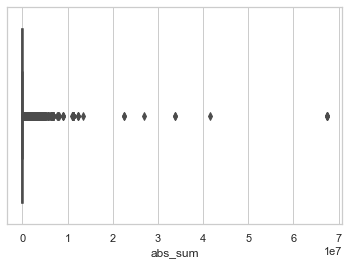

In [8]:
# boxplot which represents ouliers in absolute sum column
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=data_abs["abs_sum"])

## 1.4 Removing outlier to observe new data

Text(0.5, 1.0, 'Absolute sum boxplot')

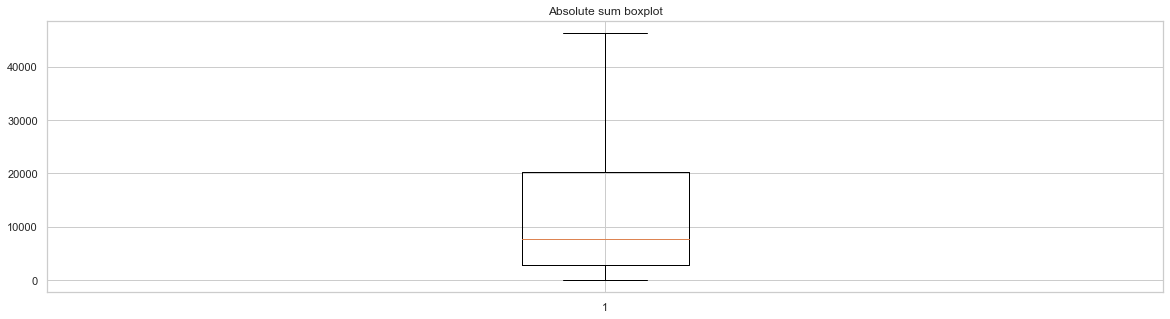

In [9]:

Q1 = data_abs['abs_sum'].quantile(0.25)
Q3 = data_abs['abs_sum'].quantile(0.75)
IQR = Q3 - Q1

No_outliers = []
for i in data_abs['abs_sum']:
    if i > (Q1 - 1.5 * IQR) and i < (Q3 + 1.5 * IQR):
        No_outliers.append(i)

No_outliers = pd.DataFrame(No_outliers)
No_outliers = No_outliers.rename(columns={0:'sum'})

plt.figure(figsize=(20, 5))

plt.subplot(1, 1, 1)
plt.boxplot(No_outliers['sum'], showfliers=False)
plt.title('Absolute sum boxplot')

## 1.5 Conclusion

**Clearing such a large number of outliers will lead to the loss of the essence of the entire clustering, so the decision was made to keep everything.**

# 2. Data Cleaning

## 2.1 Missing values

In [10]:
# copy dataset to identify missing values
data_missing_values = data.copy()
data_missing_value = data_missing_values.dropna(subset=['client_id'])

In [11]:
# information about columns in dataset 
data_missing_values.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91826 entries, 0 to 91825
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   client_id  91826 non-null  int64  
 1   datetime   91826 non-null  object 
 2   code       91826 non-null  int64  
 3   type       91826 non-null  int64  
 4   sum        91826 non-null  float64
 5   target     91826 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 4.9+ MB


Text(0.5, 1.0, 'Ratio of missing values per columns')

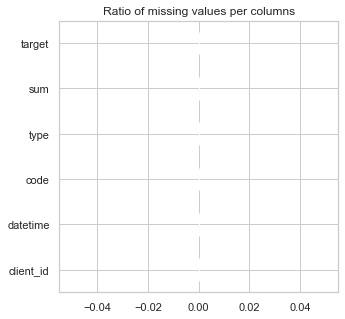

In [12]:
# at this plot we can see that 
plt.figure(figsize=(5, 5))
data_missing_values.isnull().mean(axis=0).plot.barh()
plt.title("Ratio of missing values per columns")

As the result, we can observe that the dataset has no missing values in it. Hence, it means that data was correctly scrapped.

## 2.2 Drop duplicates

In [13]:
data_duplicates = data.copy()

In [14]:
print('Dupplicate entries: {}'.format(data_duplicates.duplicated().sum()))
data_duplicates.drop_duplicates(inplace = True)

Dupplicate entries: 19


## 2.3 Data with invalid code/type values

### 2.3.1 Removing rows if their type/code is not found in codes/types tables

In [15]:
type_list = types['type'].to_list()
code_list = codes['code'].to_list()
data = data[data['type'].isin(type_list) & data['code'].isin(code_list)]

# delete unnecessary lists
del type_list, code_list

### 2.3.2 Removing rows if the description of their code/type values are invalid in codes/types tables

In [16]:
# removing н/д
nan_types = types['type'][types['type_description'] == 'н/д'].to_list()
data = data[~data['type'].isin(nan_types)]

### 2.3.3 Due to types table contains duplicates in type description we shoud remove these duplicates and replace invalid types in general dataframe 

In [17]:
# deleting duplicates of types from general data

dict_for_types = {}
for row in types.values:
    list_of_types = []
    for row2 in types.values:
        if row[1] == row2[1]:
            list_of_types.append(row2[0])
    while len(list_of_types) > 1:
        dict_for_types[list_of_types[-1]] = list_of_types[0]
        list_of_types = list_of_types[:-1]
data['type'] = data['type'].apply(lambda x: dict_for_types.get(x) if dict_for_types.get(x) != None else x)

### 2.3.4 Removing duplicates and ivalid data from types table

In [18]:
types = types.drop_duplicates('type_description', keep='first')
types = types[~types['type_description'].str.contains('н/д')]
types = types[~types['type_description'].str.contains('н/д(нет данных)')]
types = types[~types['type_description'].str.contains('XXX')]

## 2.4 New dataframe with values from types and codes tables

In [19]:
data_merged = data.merge(types).merge(codes)
del data_merged['code'], data_merged['type']
data_merged.head()

,client_id,datetime,sum,target,type_description,code_description
0,96372458,421 06:33:15,-561478.94,0,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...
1,96372458,68 02:04:11,-426724.00,0,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...
2,96372458,433 06:45:32,-112295.79,0,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...
3,21717441,55 13:38:47,-44918.32,0,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...
4,21717441,294 13:27:44,-898366.31,0,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...


# 3. Exploratory Data Analysis

## 3.1 Transaction lineplots

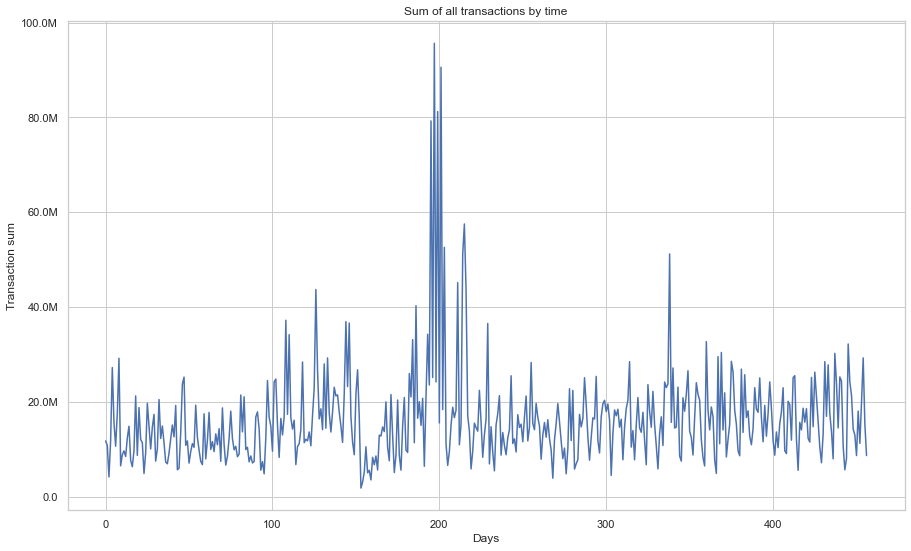

In [20]:
data_to_lineplot = data.copy()
data_to_lineplot['day'] = data_to_lineplot['datetime'].apply(lambda x: int(x.split()[0]))
data_to_lineplot['abs_sum'] = data_to_lineplot['sum'].apply(lambda x: abs(x))
def reformat_values(val, pos):
    if abs(val) >= 1000000000:
        val = round(val/1000000000)
        new_format = '{:}B'.format(val)
    elif abs(val) >= 1000000:
        val = round(val/1000000)
        new_format = '{:}M'.format(val)
    elif abs(val) >= 1000:
        val = round(val/1000)
        new_format = '{:}K'.format(val)
    elif abs(val) < 1000:
        new_format = round(val)
    else:
        new_format = val
            
    return new_format

data_to_lineplot_grouped_by_day = data_to_lineplot[['day', 'abs_sum', 'sum']].groupby('day').sum()
plt.figure(figsize = (15, 9))
plt.plot(data_to_lineplot_grouped_by_day.index, 
        data_to_lineplot_grouped_by_day['abs_sum'])
plt.xlabel('Days')
plt.ylabel('Transaction sum')
plt.title('Sum of all transactions by time')
plt.gca().yaxis.set_major_formatter(tick.FuncFormatter(reformat_values))
plt.show()

**Abnormal outliers were detected around day 200, so we are building another lineplot to determine if this was due to a withdrawal of money from the account or its replenishment.**

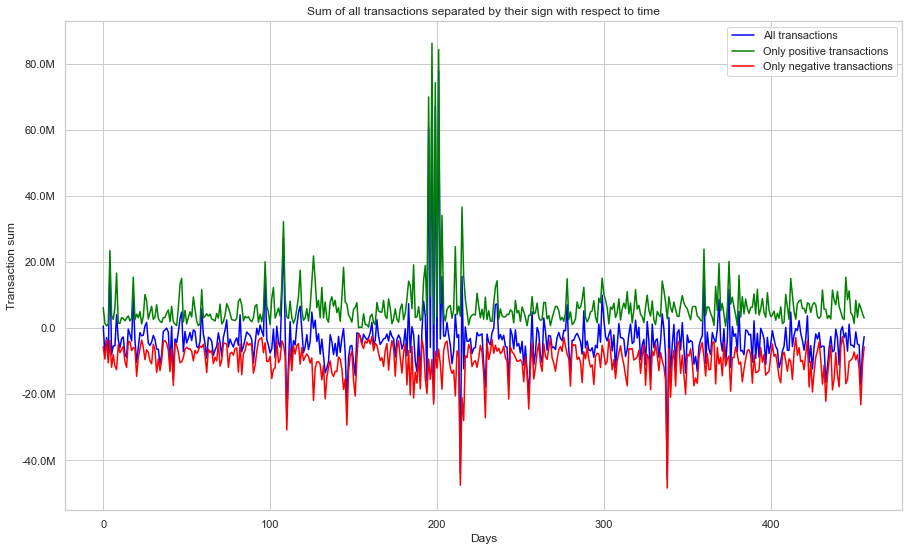

In [21]:
data_to_lineplot_only_pos = data_to_lineplot[data_to_lineplot['sum']>=0]
data_to_lineplot_only_neg = data_to_lineplot[data_to_lineplot['sum']<0]
data_to_lineplot_only_pos_grouped_by_day = data_to_lineplot_only_pos.groupby('day').sum()
data_to_lineplot_only_neg_grouped_by_day = data_to_lineplot_only_neg.groupby('day').sum()
plt.figure(figsize = (15, 9))
plt.plot(data_to_lineplot_grouped_by_day.index,
         data_to_lineplot_grouped_by_day['sum'], label = 'All transactions', color = 'blue')
plt.plot(data_to_lineplot_only_pos_grouped_by_day.index,
         data_to_lineplot_only_pos_grouped_by_day['sum'], label = 'Only positive transactions', color = 'green')
plt.plot(data_to_lineplot_only_neg_grouped_by_day.index,
         data_to_lineplot_only_neg_grouped_by_day['sum'], label = 'Only negative transactions', color = 'red')
plt.xlabel('Days')
plt.ylabel('Transaction sum')
plt.title('Sum of all transactions separated by their sign with respect to time')
plt.gca().yaxis.set_major_formatter(tick.FuncFormatter(reformat_values))
plt.legend()
plt.show()

## 3.2 Descriptive analysis of 195th day

In [22]:
data_day_195 = data_to_lineplot_only_pos[data_to_lineplot_only_pos['day'] == 195]

In [23]:
data_day_195_code = data_day_195[['sum', 'code']].groupby(['code']).sum().reset_index()
data_day_195_type = data_day_195[['sum', 'type']].groupby(['type']).sum().reset_index()

In [24]:
data_day_195_code

,code,sum
0,5641,17944.87
1,6010,69386639.78
2,6011,393035.28
3,6012,134754.95


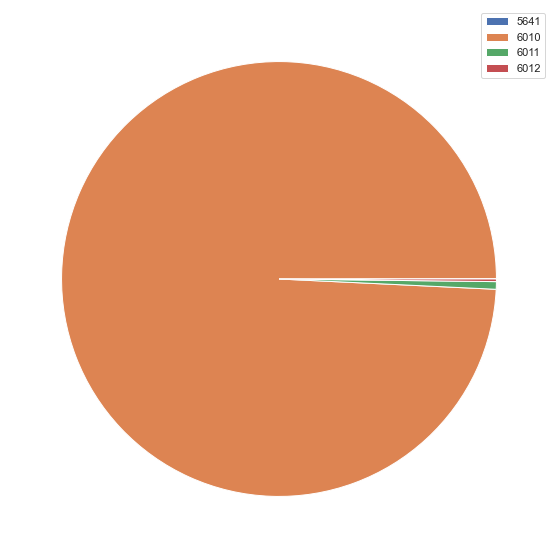

In [25]:
colors = sns.color_palette('pastel')[0:5]
plt.figure(figsize=(15, 10))
patches, texts = plt.pie(data_day_195_code['sum'])
plt.legend(patches, labels=data_day_195_code['code'], loc="best")
plt.show()

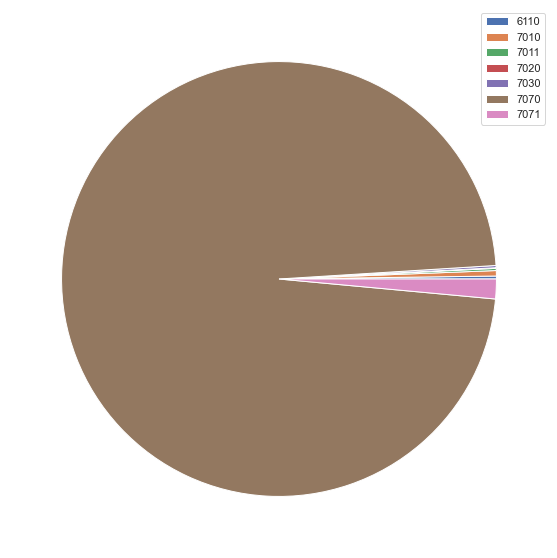

In [26]:
plt.figure(figsize=(15, 10))
patches, texts = plt.pie(data_day_195_type['sum'])
plt.legend(patches, data_day_195_type['type'], loc="best")
plt.show()

$$**As you can see, for transaction code 6010 and transaction type 7070, there are abnormal values for the amount of transactions.**

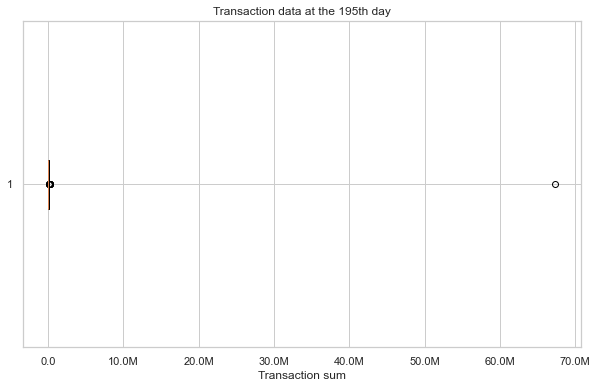

In [27]:
plt.figure(figsize=(10, 6))
plt.boxplot(data_day_195['sum'], vert = False)
plt.gca().xaxis.set_major_formatter(tick.FuncFormatter(reformat_values))
plt.xlabel('Transaction sum')
plt.title('Transaction data at the 195th day')
plt.show()

**Exploring 195th day, we can see an outlier with thr transaction with the sum of about 70 million**

Mean transaction sum 13158693.38
Median transaction sum 11229578.86


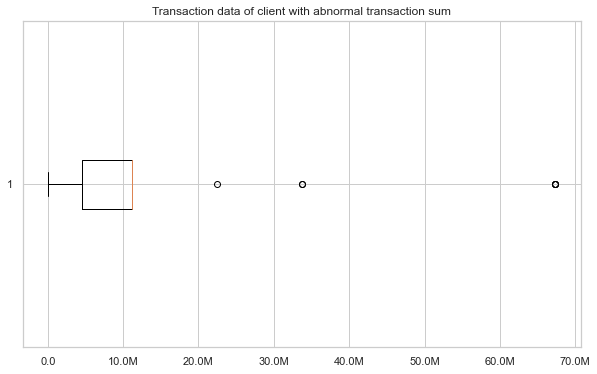

In [28]:
abnormalId = list(data_day_195[data_day_195['sum']>50000000]['client_id'])[0]
abnormalClientData = data_to_lineplot[data_to_lineplot['client_id'] == abnormalId]
print('Mean transaction sum', round(np.mean(abnormalClientData['abs_sum']), 2))
print('Median transaction sum', np.median(abnormalClientData['abs_sum']))
plt.figure(figsize=(10, 6))
plt.boxplot(abnormalClientData['abs_sum'], vert = False)
plt.title('Transaction data of client with abnormal transaction sum')
plt.gca().xaxis.set_major_formatter(tick.FuncFormatter(reformat_values))
plt.show()

**It seems that we have reached out to Putin.**

**Diving into history of client that made huge transaction, affecting whole 195th day, we can get access to his data**

## 3.3 Distribution of all transactions split by their type descriptions

In [29]:
data_merged['abs_sum'] = data_merged['sum'].apply(lambda x: abs(x))
data_to_piechart_type = data_merged.groupby('type_description').sum().sort_values('abs_sum', ascending = False).drop(['sum', 
'client_id', 'target'], axis = 1).reset_index().sort_values('abs_sum', ascending=False)
data_to_piechart_type = pd.concat([data_to_piechart_type.head(), pd.DataFrame({'type_description':'Other', 
'abs_sum':data_to_piechart_type.iloc[10:].sum()[1]}, index=[11])])
data_to_piechart_code = data_merged.groupby('code_description').sum().sort_values('abs_sum', ascending = False).drop(['sum',
'client_id', 'target'], axis = 1).reset_index().sort_values('abs_sum', ascending=False)
data_to_piechart_code = pd.concat([data_to_piechart_code.head(), pd.DataFrame({'code_description':'Other',
'abs_sum':data_to_piechart_code.iloc[10:].sum()[1]}, index=[11])])
explode = data_to_piechart_type['abs_sum'].apply(lambda x:x > 1000000000)
explode = explode.apply(lambda x:0.1 if x == True else 0)

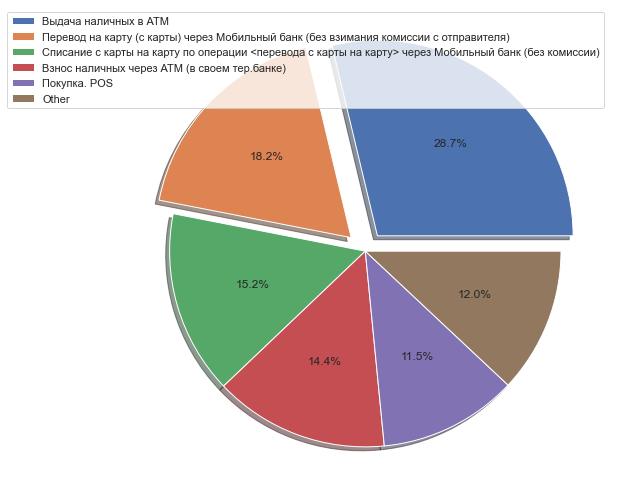

In [30]:
plt.figure(figsize=(16, 9))
patches, texts, perc = plt.pie(data_to_piechart_type['abs_sum'], explode = explode, autopct='%1.1f%%',shadow=True)
plt.legend(patches, data_to_piechart_type['type_description'], loc="best")

## 3.4 Transactions distribution by time

In [31]:
# copy dataset to work with time
hours_distribution = data.copy()
# split days and time from column datetime
hours_distribution[['day', 'time']] = hours_distribution['datetime'].str.split(' ', 1, expand=True)
# get only hours from time column
hours_distribution['time'] = pd.to_datetime(hours_distribution['time'], format='%H:%M:%S')
hours_distribution['hh']= hours_distribution['time'].dt.hour

time_hh = []
for i in hours_distribution['hh']:
    if i >=0 and i < 13:
        time_hh.append("Morning")
    elif i >= 13 and i<=17:
        time_hh.append("Afternoon")
    elif i > 17 and i <= 19:
        time_hh.append("Evening")
    elif i > 19:
        time_hh.append("Night")

# inserting times in transactions time of day column
hours_distribution["TransactionTimeOfDay"] = time_hh

In [32]:
# creating dictionary with colors
cnames = {
'aqua': '#00FFFF',
'aquamarine': '#7FFFD4',
'bisque': '#FFE4C4',
'black': '#000000',
'blanchedalmond': '#FFEBCD',
'blue': '#0000FF',
'blueviolet': '#8A2BE2',
'brown': '#A52A2A',
'burlywood': '#DEB887',
'cadetblue': '#5F9EA0',
'chartreuse': '#7FFF00',
'chocolate': '#D2691E',
'coral': '#FF7F50',
'cornflowerblue': '#6495ED',
'crimson': '#DC143C',
'cyan': '#00FFFF',
'darkblue': '#00008B',
'darkcyan': '#008B8B',
'darkgoldenrod': '#B8860B',
'darkgray': '#A9A9A9',
'darkgreen': '#006400',
'darkkhaki': '#BDB76B',
'darkmagenta': '#8B008B',
'darkolivegreen': '#556B2F',
'darkorange': '#FF8C00',
'darkorchid': '#9932CC',
'darkred': '#8B0000',
'darksalmon': '#E9967A',
'darkseagreen': '#8FBC8F',
'darkslateblue': '#483D8B',
'darkslategray': '#2F4F4F',
'darkturquoise': '#00CED1',
'darkviolet': '#9400D3',
'deeppink': '#FF1493',
'deepskyblue': '#00BFFF',
'dodgerblue': '#1E90FF',
'firebrick': '#B22222',
'forestgreen': '#228B22',
'fuchsia': '#FF00FF',
'gainsboro': '#DCDCDC',
'gold': '#FFD700',
'goldenrod': '#DAA520',
'gray': '#808080',
'green': '#008000',
'greenyellow': '#ADFF2F',
'hotpink': '#FF69B4',
'indianred': '#CD5C5C',
'indigo': '#4B0082',
'khaki': '#F0E68C',
'lavender': '#E6E6FA',
'lawngreen': '#7CFC00',
'lightcoral': '#F08080',
'lightcyan': '#E0FFFF',
'lightgreen': '#90EE90',
'lightsalmon': '#FFA07A',
'lightseagreen': '#20B2AA',
'lightskyblue': '#87CEFA',
'lightsteelblue': '#B0C4DE',
'lime': '#00FF00',
'limegreen': '#32CD32',
'linen': '#FAF0E6',
'magenta': '#FF00FF',
'maroon': '#800000',
'mediumaquamarine': '#66CDAA',
'mediumblue': '#0000CD',
'mediumorchid': '#BA55D3',
'mediumpurple': '#9370DB',
'mediumseagreen': '#3CB371',
'mediumslateblue': '#7B68EE',
'mediumspringgreen': '#00FA9A',
'mediumturquoise': '#48D1CC',
'mediumvioletred': '#C71585',
'midnightblue': '#191970',
'mistyrose': '#FFE4E1',
'moccasin': '#FFE4B5',
'navy': '#000080',
'olive': '#808000',
'olivedrab': '#6B8E23',
'orange': '#FFA500',
'orangered': '#FF4500',
'orchid': '#DA70D6',
'palegoldenrod': '#EEE8AA',
'palegreen': '#98FB98',
'paleturquoise': '#AFEEEE',
'palevioletred': '#DB7093',
'papayawhip': '#FFEFD5',
'peachpuff': '#FFDAB9',
'peru': '#CD853F',
'pink': '#FFC0CB',
'plum': '#DDA0DD',
'powderblue': '#B0E0E6',
'purple': '#800080',
'red': '#FF0000',
'rosybrown': '#BC8F8F',
'royalblue': '#4169E1',
'saddlebrown': '#8B4513',
'salmon': '#FA8072',
'sandybrown': '#FAA460',
'seagreen': '#2E8B57',
'sienna': '#A0522D',
'silver': '#C0C0C0',
'skyblue': '#87CEEB',
'slateblue': '#6A5ACD',
'slategray': '#708090',
'springgreen': '#00FF7F',
'steelblue': '#4682B4',
'tan': '#D2B48C',
'teal': '#008080',
'thistle': '#D8BFD8',
'tomato': '#FF6347',
'turquoise': '#40E0D0',
'violet': '#EE82EE',
'yellow': '#FFFF00',
'yellowgreen': '#9ACD32'}
colors = list(cnames.keys())

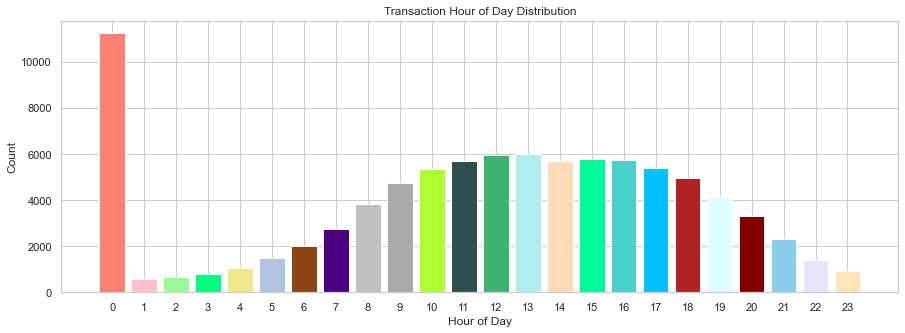

In [33]:
plt.figure(figsize=(15,5))
random.shuffle(colors)
un, count = np.unique(hours_distribution.hh.values.astype('int32'),return_counts=True)
un, count = zip(*sorted(zip(un, count)))
plt.title("Transaction Hour of Day Distribution")
plt.xlabel("Hour of Day")
plt.ylabel("Count")
plt.tick_params(bottom=False,left=False)
plt.bar([str(i) for i in un], count, color=colors)
plt.show()

This plot represents transactions distribution by time. The majority of transactions were completed at midnight. Hence, we can suggest that it was the subscription to services(e.g. Apple Music, Netflix, Spotify, YandexPlus)

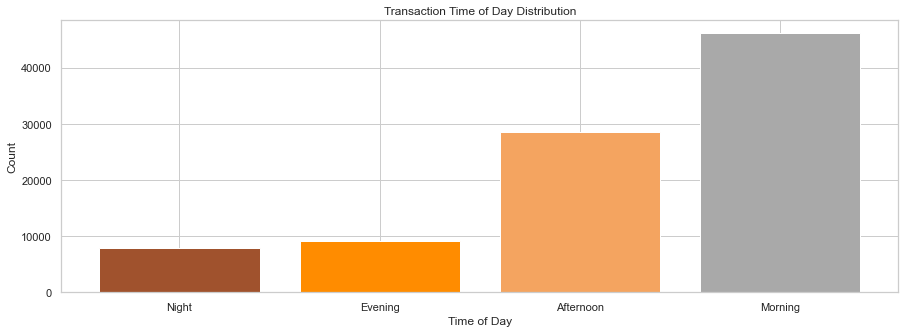

In [34]:
plt.figure(figsize=(15,5))
random.shuffle(colors)
un, count = np.unique(hours_distribution.TransactionTimeOfDay.values,return_counts=True)
count, un = zip(*sorted(zip(count, un)))
plt.title("Transaction Time of Day Distribution")
plt.xlabel("Time of Day")
plt.ylabel("Count")
plt.tick_params(bottom=False,left=False)
plt.bar(un, count, color=colors)
plt.show()

Since we put '00' (midnight) at 'morning' in the list 'the time of the day', the graph represents column 'morning' as the highest one because of the subscriptions.

# 4. Feature Engineering

**At this stage, we are going to create a new dataframe step by step by adding new features.**

## 4.1 Absolute sum of transactions (abs_sum) and account balance (sum)

In [35]:
data_to_clusterization = data.copy()
data_to_clusterization['abs_sum'] = data_to_clusterization['sum'].apply(lambda x: abs(x))
data_to_clusterization = data_to_clusterization[['sum', 'abs_sum', 'client_id']].groupby('client_id').sum()

## 4.2 Number of transactions (n_transactions)

In [36]:
data_to_clusterization = data_to_clusterization.join(data['client_id'].value_counts()).rename(columns={'client_id':'n_transactions'})

## 4.3 Average transaction (average_transaction)

In [37]:
data_to_clusterization['average_transaction'] = data_to_clusterization['abs_sum']/data_to_clusterization['n_transactions']

## 4.4 Gender (gender)

In [38]:
data_to_clusterization = data_to_clusterization.join(data[['client_id', 'target']].drop_duplicates('client_id').set_index('client_id'))
data_to_clusterization.rename(columns={'target':'gender'}, inplace=True)

## 4.5 Percentage from total sum of transactions (percentage)

In [39]:
data_merged_A = data_merged.loc[:, ['client_id', 'sum']]
data_merged_A = pd.DataFrame(data_merged_A.groupby('client_id')['sum'].apply(lambda c: c.abs().sum())).reset_index()
percentage = pd.DataFrame(data_merged_A.groupby('client_id')['sum'].apply(lambda c: c.abs().sum()) / data_merged['sum'].abs().sum()).reset_index()
data_to_clusterization = data_to_clusterization.join(percentage.set_index('client_id').rename(columns={'sum':'percentage'}))

## 4.6 Number of transactions for each cluster of code and type

### 4.6.1 Installing required library and its modules

In [40]:
!pip install nltk
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Галамат\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Галамат\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

### 4.6.2 Lists of code and type descriptions for clusterization

In [41]:
codes_text = codes['code_description'].to_list()
types_text = types['type_description'].to_list()

### 4.6.3 KMeans clusterization functions

In [42]:
import string
import collections
 
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
 
def process_text(text, stem=True):
    """ Tokenize text and stem words removing punctuation """
    text = text.translate(string.punctuation)
    tokens = word_tokenize(text)
 
    if stem:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(t) for t in tokens]
 
    return tokens
 
def cluster_texts(texts, codes, prefix, clusters=3):
    """ Transform texts to Tf-Idf coordinates and cluster texts using K-Means """
    vectorizer = TfidfVectorizer(tokenizer=process_text,
                                 stop_words=stopwords.words('russian'),
                                 max_df=0.5,
                                 min_df=0.1,
                                 lowercase=True)
 
    tfidf_model = vectorizer.fit_transform(texts)
    km_model = KMeans(n_clusters=clusters)
    km_model.fit(tfidf_model)
 
    clustering = collections.defaultdict(list)
 
    for idx, label in enumerate(km_model.labels_):
        clustering[prefix + str(label+1)].append(codes[idx-1])
 
    return clustering

articles = codes_text
codes_clusters = cluster_texts(articles, codes['code'].to_list(), 'code cluster ', 7)
articles = types_text
types_clusters = cluster_texts(articles, types['type'].to_list(),'type cluster ', 7 )

### 4.6.4 Adding new features which got from description clusterization (cluster <code/type> number)

In [43]:
def join_clusters_to_data(data_general, data, clusters, type_or_code):
    """
    For given clusters of codes/types, count the number of transaction of clusters for each client
    """
    data_clusters = data_general[['client_id', type_or_code]].copy()
    c = 1
    for key, value in dict(clusters).items():
        data_clusters[key] = 0
        c+=1
        for row in data_clusters.values:
            if row[1] in value:
                row[c] = 1
    data_clusters = data_clusters.groupby('client_id').sum()
    del data_clusters[type_or_code]
    data = data.join(data_clusters)
    return data

data_to_clusterization = join_clusters_to_data(data, data_to_clusterization, codes_clusters, 'code')
data_to_clusterization = join_clusters_to_data(data, data_to_clusterization, types_clusters, 'type')

## 4.7 Time of registration in minutes (time_of_registration) and difference between transactions in minutes (transaction_frequecy)

In [44]:
data_with_time = data[['client_id', 'datetime']].copy()
data_with_time['day'] = data['datetime'].apply(lambda x: int(x.split()[0]))
data_with_time['time'] = data['datetime'].apply(lambda x: x.split()[1])
data_with_time['hh'] = data_with_time['time'].apply(lambda x: int(x.split(':')[0]))
data_with_time['mm'] = data_with_time['time'].apply(lambda x: int(x.split(':')[1]))
data_with_time['time_of_registration'] = 24*60*data_with_time['day'] + 60 * 24*60*data_with_time['hh'] + data_with_time['mm']
last_date = data_with_time['time_of_registration'].max()
del data_with_time['time']
del data_with_time['datetime']
del data_with_time['day']
del data_with_time['hh']
del data_with_time['mm']

In [45]:
data_with_time = data_with_time.sort_values('time_of_registration').drop_duplicates('client_id', keep='first')
data_with_time = data_with_time.set_index('client_id').join(data_to_clusterization['n_transactions'])

In [46]:
data_with_time['transaction_frequecy'] = (last_date - data_with_time['time_of_registration'])/data_with_time['n_transactions']

In [47]:
del data_with_time['n_transactions']
data_to_clusterization = data_to_clusterization.join(data_with_time)

## 4.8 RFM features - Recency, Frequency, Monetary values

Calculate and add 3 features that will be used in RFM analysis - Recency(how long ago was last action done), Frequency(how much transactions were made overall), Monetary - total sum of transaction

In [48]:
rfmData = data.copy()
rfmData.drop_duplicates(inplace = True)
rfmData[['day', 'datetime']] = rfmData['datetime'].str.split(' ', 1, expand=True)
rfmData2 = rfmData.copy()
rfmData2['monetary'] = rfmData2['sum'].apply(lambda x: float(abs(x)))
groupedRfm = rfmData2.groupby('client_id').sum().drop(['code', 'type', 'target', 'sum'], axis = 1)
groupedRfm['recency'] = rfmData2.groupby('client_id').max()['day'].apply(lambda x: 457 - int(x)).to_list()
groupedRfm['frequency'] = rfmData2.groupby('client_id').count()['day'].to_list()

In [49]:
groupedRfm.head()

,monetary,recency,frequency
client_id,,,
22899,119842.08,391,9
27914,83098.89,165,4
28753,3937349.75,366,13
38084,2810132.96,377,26
49793,1436315.95,376,21


## 4.9 Final results of Feature Engineering

In [50]:
data_to_clusterization.head()

,sum,abs_sum,n_transactions,average_transaction,gender,percentage,code cluster 5,code cluster 3,code cluster 1,code cluster 2,...,code cluster 7,type cluster 4,type cluster 3,type cluster 2,type cluster 7,type cluster 5,type cluster 6,type cluster 1,time_of_registration,transaction_frequecy
client_id,,,,,,,,,,,,,,,,,,,,,
22899,50847.54,119842.08,9,13315.786667,1,0.000016,1,5,1,0,...,0,1,1,3,0,0,2,2,1018130,180480.222222
27914,74115.21,83098.89,4,20774.722500,1,0.000011,2,1,0,0,...,0,0,0,2,0,1,0,1,1153473,372244.750000
28753,-2589800.29,3937349.75,13,302873.057692,0,0.000527,3,5,1,3,...,0,0,0,10,0,0,0,3,161280,190859.384615
38084,693495.66,2810132.96,26,108082.036923,0,0.000376,3,13,0,9,...,0,0,0,16,0,0,0,10,171360,95042.000000
49793,-1382413.97,1436315.95,21,68395.997619,1,0.000192,6,5,0,10,...,0,0,0,19,0,0,0,2,73440,122333.904762


# 5. Data Preprocessing

In [51]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import Normalizer

## 5.1 Non-linear transformation. Mapping to a Uniform distribution (Quantile transformer)

In [52]:
data_exp = QuantileTransformer(n_quantiles=10, random_state=0, output_distribution='normal').fit_transform(np.sort(data_to_clusterization))

## 5.2 Normalization

In [53]:
data_exp_norm = Normalizer().fit(data_exp).transform(data_exp)

## Conclusion

**Spending a huge amount of time on the selection and testing of possible combinations of standardization, non-linear transformation, normalization and other preprocessing activities we have found through experience that the most appropriate course of action at this stage would be non-linear transformation (Quantile transformer) an normalization(Normalizer).**

**It is with this combination that machine learning models give the best result.**

**This can be explained by the fact that both methods are robust to outliers.**

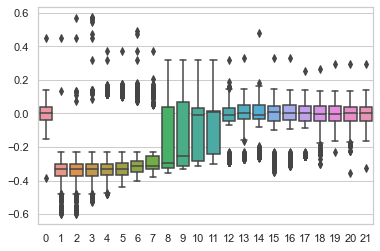

In [54]:
sns.boxplot(data = data_exp_norm)

# 6. RFM Analysis

## 6.1 Calculating feature scores.

In [55]:
groupedRfm["recencyScore"] = pd.cut(groupedRfm["recency"],
                                       bins=[0, 
                                         np.percentile(groupedRfm["recency"], 25), 
                                             np.percentile(groupedRfm["recency"], 50), 
                                             np.percentile(groupedRfm["recency"], 75), 
                                             groupedRfm["recency"].max()], 
                                       labels=[4, 3, 2, 1]).astype("int")
groupedRfm["frequencyScore"] = pd.cut(groupedRfm["frequency"], 
                                       bins=[0, 
                                         np.percentile(groupedRfm["frequency"], 25), 
                                             np.percentile(groupedRfm["frequency"], 50), 
                                             np.percentile(groupedRfm["frequency"], 75), 
                                             groupedRfm["frequency"].max()], 
                                       labels=[1, 2, 3, 4]).astype("int")
groupedRfm["monetaryScore"] = pd.cut(groupedRfm["monetary"], 
                                       bins=[0, 
                                         np.percentile(groupedRfm["monetary"], 25), 
                                             np.percentile(groupedRfm["monetary"], 50), 
                                             np.percentile(groupedRfm["monetary"], 75), 
                                             groupedRfm["monetary"].max()], 
                                       labels=[1, 2, 3, 4]).astype("int")
groupedRfm['rfmScore'] = groupedRfm["monetaryScore"] + groupedRfm["recencyScore"] + groupedRfm["frequencyScore"]
groupedRfm['rfmStr'] = groupedRfm["recencyScore"].apply(lambda x: str(x)) \
    + groupedRfm["frequencyScore"].apply(lambda x: str(x)) + groupedRfm["monetaryScore"].apply(lambda x: str(x))
groupedRfm

,monetary,recency,frequency,recencyScore,frequencyScore,monetaryScore,rfmScore,rfmStr
client_id,,,,,,,,
22899,119842.08,391,9,1,2,1,4,121
27914,83098.89,165,4,3,1,1,5,311
28753,3937349.75,366,13,2,3,4,9,234
38084,2810132.96,377,26,2,4,4,10,244
49793,1436315.95,376,21,2,4,4,10,244
...,...,...,...,...,...,...,...,...
99900908,72052.13,146,5,3,1,1,5,311
99911226,667589.93,363,12,3,3,3,9,333
99967537,336887.37,125,1,3,1,2,6,312


## 6.2 Segment customers to find lost and most active bank users

In [56]:
rfmData = groupedRfm[['rfmStr', 'recency', 'frequency', 'monetary']]
print('Most valuable bank users')
print('There are', rfmData[rfmData['rfmStr'] == '444'].shape[0], '"golden" customers')
rfmData[rfmData['rfmStr'] == '444'].head()

Most valuable bank users
There are 50 "golden" customers


,rfmStr,recency,frequency,monetary
client_id,,,,
374768,444,31,25,2105227.79
683284,444,24,20,1901972.65
1013842,444,4,31,27173352.45
3075545,444,1,52,5015754.14
3453773,444,9,28,3487012.22


In [57]:
wereActive = rfmData[(groupedRfm['recencyScore'] < 3) & (groupedRfm['frequencyScore'] > 2) & (groupedRfm['monetaryScore'] > 2)]
print('Bank users that used to make large transactions in past')
print('There are', wereActive.shape[0], 'lost customers')
wereActive

Bank users that used to make large transactions in past
There are 1258 lost customers


,rfmStr,recency,frequency,monetary
client_id,,,,
28753,234,366,13,3937349.75
38084,244,377,26,2810132.96
49793,244,376,21,1436315.95
126081,243,366,22,665846.66
218079,233,371,15,429203.71
...,...,...,...,...
99452850,234,375,15,2649199.15
99483281,244,375,30,1684460.45
99568688,134,393,17,2526062.77


## 6.3 Conclusion

We segmented customers according to their total RFM score. Each customer has its own calculated score which depends on his transaction activity and recency. Score can vary in range of 3-12 and the larger score, the more valuable customer is. However, total score itself cannot give descriptive information, that's why we decided to make RFM score with respect to each feature and it ranges from '111' till '444', where each number accords to Recency, Frequency, Monetary features respectively.

After calculating descriptive, string-like RFM score, we can segment bank users by their activity, as we did few cells ago. We got the most active and valuable, so-called 'golden' customers, who often use our bank and make transactions with big sums. This customers must be rewarded for their trust to bank by giving them special offers or privileges.

We also found 'lost' customers that used to use our bank quite often and make large transactions, but for some reason they stopped using our bank. Such customers must be involved in our bamk again, by sending them target messages with special offers or having phone calls.

# 7. Model Selection

**In this chapter, we are going to implement 2 of the most popular clustering algorithms: KMeans and Agglomerative Clustering. There will also be selected optimal hyperparameters, and the performance of the models will be evaluated by metrics. At the end, we will create a visualization of the results obtained and compare them.**

In [58]:
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn import metrics
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 2)

## 7.1 KMeans clusterization

### 7.1.1 Choosing the optimal number of clusters

In [59]:
def drawSSEPlot(df, column_indices, n_clusters=50, max_iter=300, tol=1e-04, init='k-means++', n_init=10, algorithm='auto'):
    """
    For given dataframe, construct a lineplot of SSE for KMeans clustering
    """
    import matplotlib.pyplot as plt
    inertia_values = []
    for i in range(1, n_clusters+1):
        km = KMeans(n_clusters=i, max_iter=max_iter, tol=tol, init=init, n_init=n_init, random_state=1, algorithm=algorithm)
        km.fit_predict(df.iloc[:, column_indices])
        inertia_values.append(km.inertia_)
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.plot(range(1, n_clusters+1), inertia_values, color='red')
    plt.xlabel('No. of Clusters', fontsize=15)
    plt.ylabel('SSE / Inertia', fontsize=15)
    plt.title('SSE / Inertia vs No. Of Clusters', fontsize=15)
    plt.grid()
    plt.show()

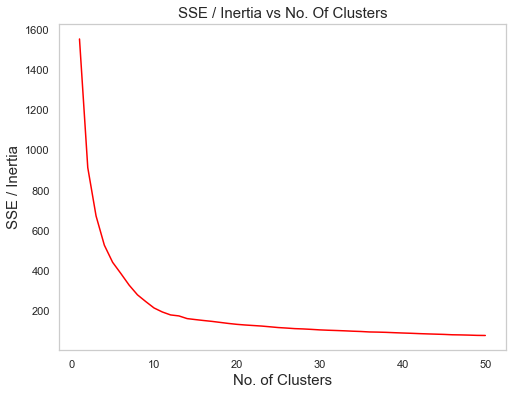

In [60]:
drawSSEPlot(pd.DataFrame(data_exp_norm), list(range(0, 22)))

**Sum Squared Error (SSE) is an accuracy measure where the errors are squared, then added. It is used to determine the accuracy of the forecasting model when the data points are similar in magnitude.**

In [61]:
list_scores_1 = []
list_scores_2 = []
list_scores_3 = []
for i in range(2, 50):
    kmeans = KMeans(n_clusters=i, n_init=50).fit(data_exp_norm)
    labels = kmeans.labels_
    labels2 = kmeans.fit_predict(data_exp_norm)
    list_scores_1.append(metrics.silhouette_score(data_exp_norm, labels))
    list_scores_2.append(metrics.calinski_harabasz_score(data_exp_norm, labels))
    list_scores_3.append(metrics.davies_bouldin_score(data_exp_norm, labels2))

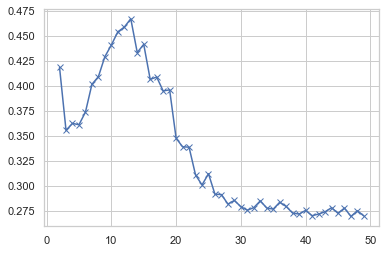

In [62]:
plt.plot(list(range(2, 50)), list_scores_1, 'bx-')

**The Silhouette Coefficient is an example of such an evaluation, where a higher Silhouette Coefficient score relates to a model with better defined clusters. The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.**

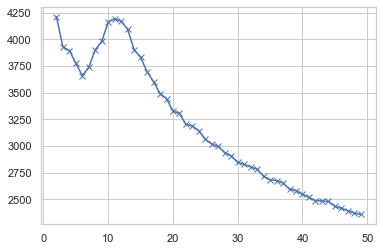

In [63]:
plt.plot(list(range(2, 50)), list_scores_2, 'bx-')

**The Calinski-Harabasz index - can be used to evaluate the model, where a higher Calinski-Harabasz score relates to a model with better defined clusters. The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.**

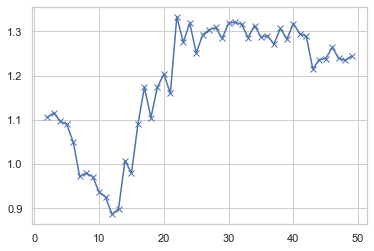

In [64]:
plt.plot(list(range(2, 50)), list_scores_3, 'bx-')

**The Davies-Bouldin index can be used to evaluate the model, where a lower Davies-Bouldin index relates to a model with better separation between the clusters.**

### 7.1.1.1 Conclusion from chapter above

**Based on the graphs above, we can assume that the optimal number of clusters will be 14 clusters.**

### 7.1.2 KMeans model

In [65]:
kmeans = KMeans(n_clusters=14, n_init=100).fit(data_exp_norm)
kmeans_labels = kmeans.labels_

### 7.1.3 Cross-Validation Score

In [66]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
abs(cross_val_score(kmeans, data_exp_norm, cv=cv))

array([48.69961848, 49.89048535, 49.01143839, 49.22346761, 49.44969741])

**How you can see above, Cross-Validation Score is very small that says about well-chosen hyperparameters and good data preprocessing.**

### 7.1.4 TSNE Visualization

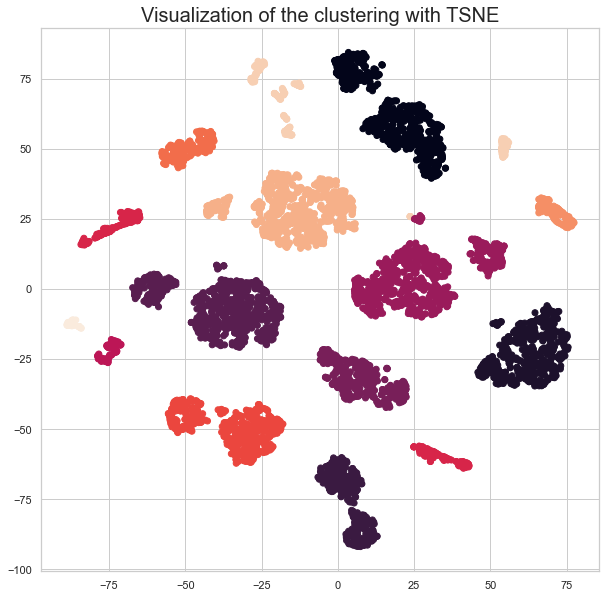

In [67]:
proj = tsne.fit_transform(data_exp_norm)
plt.figure(figsize=(10,10))
plt.scatter(proj[:,0], proj[:,1], c=kmeans_labels)
plt.title("Visualization of the clustering with TSNE", fontsize="20")
plt.show()

**You can clearly see how qualitatively the data is divided into clusters.**

## 7.2 Agglomerative Clustering

In [68]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import scipy.cluster.hierarchy as shc

### 7.2.1 Agglomerative clustering model

**After doing a lot of experiments and relying on the same metrics as in KMeans clustering, it was determined that the best linkage for agglomerative clustering is "ward".**

In [73]:
linkage = 'ward'
aggclustering = AgglomerativeClustering(n_clusters=12, linkage=linkage, affinity='euclidean').fit(data_exp_norm)

### 7.2.2 Metrics

In [74]:
aggclustering_2 = AgglomerativeClustering(n_clusters=12, linkage=linkage, affinity='euclidean').fit_predict(data_exp_norm)

# retrieve unique clusters
clusters = np.unique(aggclustering)

# Calculate cluster validation metrics
score_AGclustering_s = metrics.silhouette_score(data_exp_norm, aggclustering.labels_, metric='euclidean')
score_AGclustering_c = metrics.calinski_harabasz_score(data_exp_norm, aggclustering.labels_)
score_AGclustering_d = metrics.davies_bouldin_score(data_exp_norm, aggclustering_2)
print('Silhouette Score: %.4f' % score_AGclustering_s)
print('Calinski Harabasz Score: %.4f' % score_AGclustering_c)
print('Davies Bouldin Score: %.4f' % score_AGclustering_d)

Silhouette Score: 0.4604
Calinski Harabasz Score: 4016.2789
Davies Bouldin Score: 0.9554


**Exactly because of ward linkage, the model produces the greatest result in Silhouette, Calinski and Davis Bouldin metrics.**

### 7.2.3 Match with KMeans results

In [75]:
aggclust_labels = aggclustering.labels_
correlation_btw_kmeans_aggclust = 0
for i in np.unique(kmeans_labels):
    correlation_btw_kmeans_aggclust += sum(np.sort(np.unique(aggclust_labels[np.where(kmeans_labels == i)], return_counts=True)[1])[::-1][1:])
print(1 - correlation_btw_kmeans_aggclust / len(kmeans_labels))

0.9935


**And as you can see, the results are 99% the same as those obtained with KMeans clustering.**

### 7.2.4 Dendogram

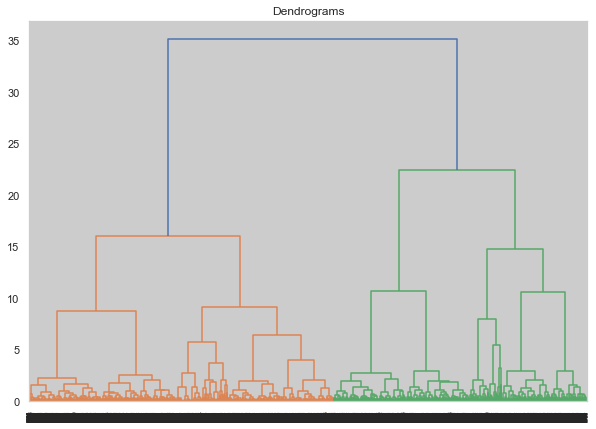

In [76]:
import scipy.cluster.hierarchy as shc
from matplotlib import pyplot
pyplot.figure(figsize=(10, 7))  
pyplot.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(data_exp_norm, method='ward'))

### 7.2.5 TSNE Visualization

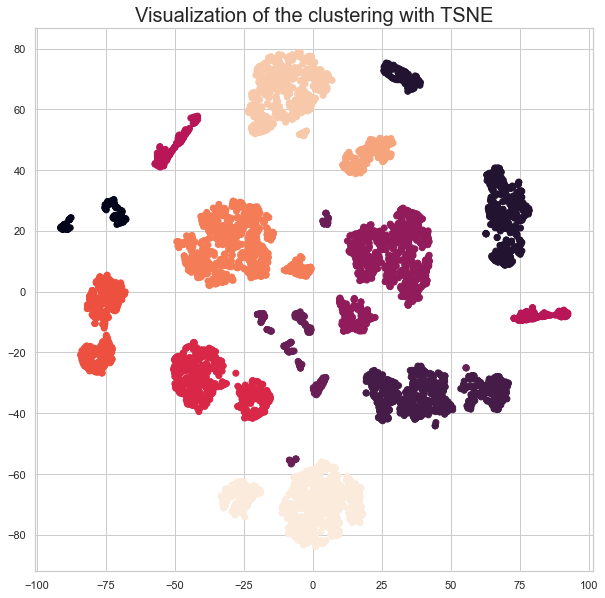

In [77]:
proj = tsne.fit_transform(data_exp_norm)
plt.figure(figsize=(10,10))
plt.scatter(proj[:,0], proj[:,1], c=aggclust_labels)
plt.title("Visualization of the clustering with TSNE", fontsize="20")
plt.show()

## 7.3 Conclusion

**In this section, we segmented customer data into 14 clusters.**

**This number was chosen based on the conducted model selection, after which the models of KMeans and Agglomerative clustering algorithms were created.**

**According to the assessment, it can be concluded that both algorithms give impressive results: there are no outliers and stratifications of clusters, their boundaries are very clearly defined and they are able to characterize one or another feature of their group.**

# 8. Final conclusion

In [80]:
list_mean = []
for i in np.unique(kmeans_labels):
    list_mean.append(data_to_clusterization[kmeans_labels == i].mean().round())
clusters_final = pd.DataFrame(list_mean)
clusters_final

,sum,abs_sum,n_transactions,average_transaction,gender,percentage,code cluster 5,code cluster 3,code cluster 1,code cluster 2,...,code cluster 7,type cluster 4,type cluster 3,type cluster 2,type cluster 7,type cluster 5,type cluster 6,type cluster 1,time_of_registration,transaction_frequecy
0,-405200.0,1265410.0,19.0,79677.0,0.0,0.0,3.0,6.0,1.0,6.0,...,0.0,1.0,1.0,14.0,0.0,0.0,0.0,2.0,452374.0,152591.0
1,-238197.0,271015.0,7.0,44396.0,0.0,0.0,2.0,3.0,0.0,2.0,...,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,771820.0,320922.0
2,-391144.0,3217654.0,37.0,110600.0,1.0,0.0,4.0,8.0,2.0,9.0,...,0.0,3.0,11.0,17.0,1.0,0.0,1.0,5.0,328011.0,107611.0
3,-76633.0,1828015.0,15.0,85929.0,0.0,0.0,3.0,5.0,1.0,5.0,...,0.0,0.0,0.0,12.0,0.0,0.0,0.0,2.0,528215.0,185284.0
4,-261170.0,278454.0,5.0,73357.0,0.0,0.0,1.0,2.0,0.0,1.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,987093.0,417846.0
5,-356965.0,595916.0,12.0,64801.0,0.0,0.0,2.0,4.0,0.0,4.0,...,0.0,0.0,0.0,10.0,0.0,0.0,0.0,1.0,608247.0,235934.0
6,710291.0,5897245.0,39.0,161051.0,1.0,0.0,4.0,11.0,3.0,12.0,...,0.0,3.0,5.0,22.0,1.0,1.0,1.0,7.0,230867.0,75396.0
7,-104422.0,104422.0,1.0,104422.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1449169.0,1193283.0
8,-526827.0,1874200.0,23.0,92550.0,1.0,0.0,3.0,7.0,1.0,7.0,...,0.0,1.0,3.0,15.0,0.0,0.0,0.0,3.0,379654.0,133312.0
9,84853.0,3426097.0,39.0,115339.0,1.0,0.0,4.0,9.0,3.0,10.0,...,0.0,4.0,9.0,19.0,1.0,0.0,1.0,5.0,290576.0,91568.0


Best customers:

The 13s cluster represents best customers according to their transactions. The thing we can notice here that these customers are  has the biggest amount of money and their money flow is high as well. They have the same amount of transaction with the 9th cluster (61/61). The gender of these class are males.

The 9th cluster shows us information about customers who created their accounts earlier then best customers and use SberBank for transactions more often then other customers.

The 3rd cluster contains customers with positive amount of money on their accounts, however money on their accounts, the whole money flow, and amount of transactions are twice lower then first two clusters.

These 3 clusters are our best customers and use SberBank fuctionality really often. We also can say they are the oldest customers of this bank. From code Clusters its  obvious golden customers to many transactions on code cluster 1 and code cluster 4 types of services or stuff and prefer to use type 4 cluster for transactions.

Big spenders:

The 7th cluster is people who have almost the lowest amount on their accounts but their total sum of transaction is the biggest. This cluster really near by to the best customers they are quite good, they do not do that much of transactions (35 in average) but amount of avereage transaction is bigger in commparison with other clusters.

The 5th cluster has a lot in common with the 7th one. Spent lots of money, not that often, but by the big amount of money in average.

These two clusters are good enough, might be for some reason they dont do as many transactions as best customers, we can say at first they have registered later, at second during less time and less transaction number they spend more money in total.

Average customers:

The 1st cluster of customers are not that loyal, they do 20 transactions and far away from our standarts of the best customers. We can say that  this cluster in total is in the middle. There is nothing to specify about it. But they have the lowest amount of money on their accounts.

The 11th, 4th and 2nd clusters are also pretty average. We cant say much about them, they have registered comparatively recently, so we need give them a bit more time.

Almost lost:

The 6th cluster, these customers are do rare transactions and average transactions of threse customers are low as well. 

The 12th cluster with the smallest amount of transaction money. But in the same time they do transaction more often then other 3 clusters in our almost lost type.

The 0th cluster is something in the middle between 6th, 12th and 8th, 10th clusters, we almost lost them so we need to pay more attention to them.

The 8th cluster represents the customers we almost lost, interesting thing about it that this cluser majorly represented by males. Meanwhile all other male clusters are best customers according to their features. 

The 10th cluster customers do most rare transaction, and usage of time is the smallest as well.



<img src = 'https://c.tenor.com/O9UBlrcr_HwAAAAC/amelia-watson-watson.gif'>
<img src = 'https://c.tenor.com/KuhLbye2DeAAAAAC/amelia-watson-hololive.gif'>